<a href="https://colab.research.google.com/github/packtpublishing/Machine-Learning-for-Imbalanced-Data/blob/main/chapter07/Cutmix_mixup_remix_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running a default CNN model on Fashion MNIST dataset to benchmark it's accuracy


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import time
import torchvision
import random
import copy
import cv2
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

seed = 44
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64)  # 4608 is basically 12 X 12 X 32
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        return x

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def train(
    train_dataloader,
    valid_dataloader,
    PATH,
    model=None,
    criterion=F.cross_entropy,
    epochs=1,
):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    model.train()
    best_acc = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        losses = 0
        for b_i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss = criterion(pred_prob, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses += loss.item()  # print(losses)
            if b_i % 10 == 0:
                print(
                    "epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}".format(
                        epoch,
                        b_i,
                        len(train_dataloader),
                        100.0 * b_i / len(train_dataloader),
                        loss.item(),
                    )
                )
        train_losses.append(losses / len(train_dataloader))
        print("\n")
        print("Validation...")
        model.eval()
        success = 0
        total = 0
        losses = 0
        with torch.no_grad():
            for X, y in valid_dataloader:
                X, y = X.to(device), y.to(device)
                pred_prob = model(X)
                loss = criterion(pred_prob, y)  # loss summed across the batch
                losses += loss.item()
                pred = pred_prob.argmax(
                    dim=1, keepdim=True
                )  # use argmax to get the most likely prediction
                success += pred.eq(y.view_as(pred)).sum().item()
                total += len(y)
        val_losses.append(losses / len(valid_dataloader))
        accuracy = 100.0 * success / total

        if accuracy > best_acc:
            torch.save(model.state_dict(), PATH)
            best_acc = accuracy

        print(
            "\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n".format(
                losses / len(valid_dataloader), success, total, accuracy
            )
        )
    return model, train_losses, val_losses


def test(model, PATH, criterion=F.cross_entropy):
    model.eval()
    model.load_state_dict(torch.load(PATH))
    losses = 0
    success = 0
    correct = 0
    class_correct = list(0.0 for i in range(10))
    class_total = list(0.0 for i in range(10))
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            losses += criterion(pred_prob, y).item()  # loss summed across the batch
            pred = pred_prob.argmax(
                dim=1, keepdim=True
            )  # use argmax to get the most likely prediction
            correct = np.squeeze(pred.eq(y.view_as(pred)))
            success += pred.eq(y.view_as(pred)).sum().item()

    losses /= len(test_dataloader.dataset)

    accuracy = 100.0 * success / len(test_dataloader.dataset)

    print(
        "\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n".format(
            losses, success, len(test_dataloader.dataset), accuracy
        )
    )

    for i in range(len(y)):
        label = y[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    class_percentages = []
    for i in range(len(class_correct)):
        class_percentages.append(class_correct[i] / class_total[i])

    return accuracy, class_percentages

## Orignal Fashion Mnist Dataset Class distribution

100%|██████████| 26421880/26421880 [00:01<00:00, 16409269.59it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 280881.53it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5023091.59it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20821867.88it/s]


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})
Distribution of classes in original dataset:


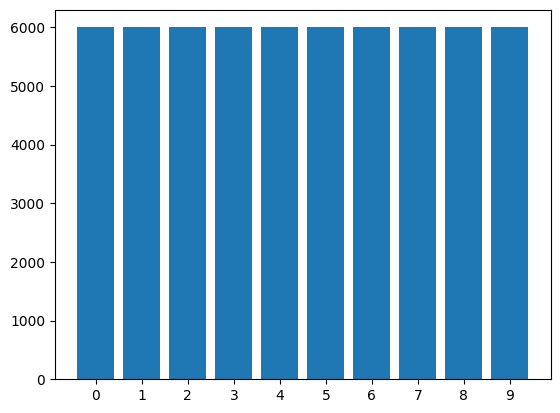

train_size 48000
val_size 12000


In [5]:
trainset = datasets.FashionMNIST(
    "../data",
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1302,), (0.3069,))]
    ),
)
print(Counter(trainset.targets.numpy()))

print("Distribution of classes in original dataset:")
fig, ax = plt.subplots()
_, counts = np.unique(trainset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.show()

# Preparing for validaion test
indices = list(range(len(trainset)))
np.random.seed(seed)
np.random.shuffle(indices)
# to get 20% of the train set
split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[split:])
valid_sample = SubsetRandomSampler(indices[:split])

# Data Loader
train_dataloader = torch.utils.data.DataLoader(
    trainset, sampler=train_sample, batch_size=64
)
valid_dataloader = torch.utils.data.DataLoader(
    trainset, sampler=valid_sample, batch_size=64
)
print("train_size", len(train_sample))
print("val_size", len(valid_sample))

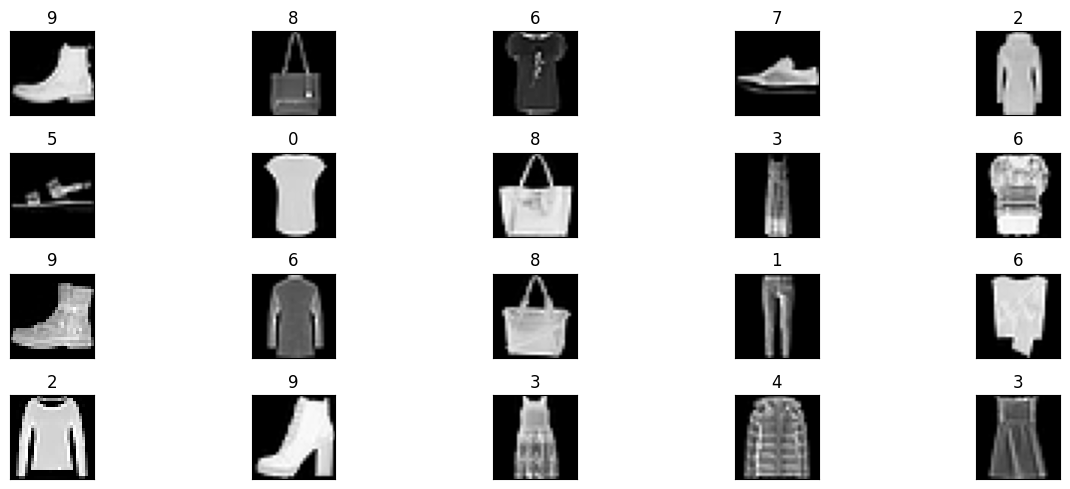

In [6]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)


fig = plt.figure(figsize=(15, 5))
for idx in np.arange(20):
    # xticks=[], yticks=[] is empty to print the images without any ticks around them
    # np.sqeeze : Remove single-dimensional entries from the shape of an array.
    ax = fig.add_subplot(4, int(20 / 4), idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap="gray")
    # .item() gets the value contained in a Tensor
    ax.set_title(labels[idx].item())
    fig.tight_layout()

In [7]:
test_ds = datasets.FashionMNIST(
    "../data",
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1302,), (0.3069,))]
    ),
)

test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=500)

# Balanced/Orignal Dataset Training

In [8]:
model, train_losses, val_losses = train(
    train_dataloader,
    valid_dataloader,
    "Balanced_model.pth",
    ConvNet().to(device),
    epochs=10,
)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 0 [0/750 (0%)]	 training loss: 2.306934
epoch: 0 [10/750 (1%)]	 training loss: 1.508018
epoch: 0 [20/750 (3%)]	 training loss: 1.118173
epoch: 0 [30/750 (4%)]	 training loss: 0.885390
epoch: 0 [40/750 (5%)]	 training loss: 0.755212
epoch: 0 [50/750 (7%)]	 training loss: 0.913945
epoch: 0 [60/750 (8%)]	 training loss: 0.929232
epoch: 0 [70/750 (9%)]	 training loss: 0.778155
epoch: 0 [80/750 (11%)]	 training loss: 0.994409
epoch: 0 [90/750 (12%)]	 training loss: 0.741211
epoch: 0 [100/750 (13%)]	 training loss: 0.608615
epoch: 0 [110/750 (15%)]	 training loss: 0.428522
epoch: 0 [120/750 (16%)]	 training loss: 0.573671
epoch: 0 [130/750 (17%)]	 training loss: 0.838935
epoch: 0 [140/750 (19%)]	 training loss: 0.464045
epoch: 0 [150/750 (20%)]	 training loss: 0.712092
epoch: 0 [160/750 (21%)]	 training loss: 0.573884
epoch: 0 [170/750 (23%)]	 training loss: 0.617408
epoch: 0 [180/750 (24%)]	 training loss: 0.419022
epoch: 0 [190/750 (25%)]	 training loss: 0.719708
epoch: 0 [200/750 (

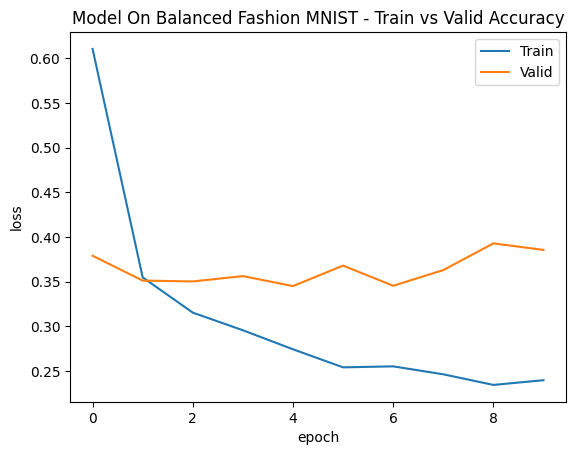

In [9]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Train", "Valid"])
plt.title("Model On Balanced Fashion MNIST - Train vs Valid Accuracy")

plt.show()

# Test Model

In [10]:
print("On vanilla Fashion MNIST dataset")
test_acc, _ = test(model, "Balanced_model.pth")
print("test accuracy : ", str(test_acc))

On vanilla Fashion MNIST dataset

Test dataset: Overall Loss: 0.0008, Overall Accuracy: 8793/10000 (88%)

test accuracy :  87.93


# Performance of the Model on Imbalanced MNIST Dataset

### Create Imbalanced Dataset

Distribution of classes in Imbalanced dataset:
Counter({0: 6000, 1: 3596, 2: 2156, 3: 1292, 4: 774, 5: 464, 6: 278, 7: 166, 8: 100, 9: 60})


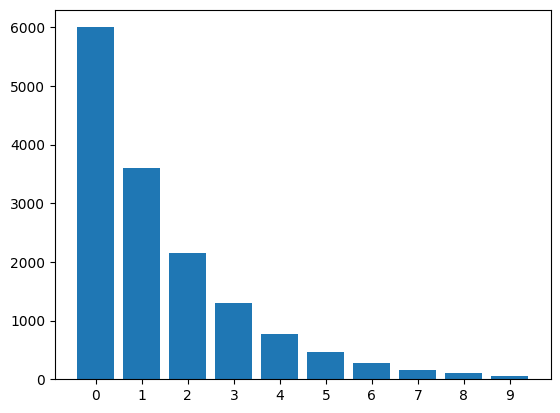

train_size 11909
val_size 2977


In [11]:
# generate imbalanced dataset
num_classes = 10
classe_labels = range(num_classes)
torch.manual_seed(seed)
sample_probs = torch.rand(num_classes)
idx_to_remove = []


def get_img_num_per_cls(data, num_classes=10, imb_type="exp", imb_factor=0.01):
    img_max = len(data) / num_classes
    img_num_per_cls = []
    if imb_type == "exp":
        for cls_idx in range(num_classes):
            num = img_max * (imb_factor ** (cls_idx / (num_classes - 1.0)))
            img_num_per_cls.append(int(num))
    return img_num_per_cls


def gen_imbalanced_data(targets, img_num_per_cls):
    targets_np = np.array(targets, dtype=np.int64)
    classes = np.unique(targets_np)
    num_per_cls_dict = dict()
    idx_to_remove = []
    for the_class, the_img_num in zip(classes, img_num_per_cls):
        num_per_cls_dict[the_class] = the_img_num
        idx = np.where(targets_np == the_class)[0]
        np.random.shuffle(idx)
        selec_idx = idx[:the_img_num]
        idx_to_remove.extend(list(np.setdiff1d(idx, selec_idx)))
    return idx_to_remove


img_num_per_cls = get_img_num_per_cls(trainset)
idx_to_remove = gen_imbalanced_data(trainset.targets, img_num_per_cls)

# print('idx_to_remove: ', idx_to_remove)
imbalanced_train_dataset = copy.deepcopy(trainset)
imbalanced_train_dataset.targets = np.delete(trainset.targets, idx_to_remove, axis=0)
imbalanced_train_dataset.data = np.delete(trainset.data, idx_to_remove, axis=0)

print("Distribution of classes in Imbalanced dataset:")
print(Counter(imbalanced_train_dataset.targets.numpy()))
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_dataset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.show()

# Preparing for validaion test
indices = list(range(len(imbalanced_train_dataset)))
np.random.seed(seed)
np.random.shuffle(indices)
# to get 20% of the train set
split = int(np.floor(0.2 * len(imbalanced_train_dataset)))
train_sample = SubsetRandomSampler(indices[split:])
valid_sample = SubsetRandomSampler(indices[:split])

# Data Loader
imbalanced_train_loader = torch.utils.data.DataLoader(
    imbalanced_train_dataset, sampler=train_sample, batch_size=64
)
imbalanced_valid_loader = torch.utils.data.DataLoader(
    imbalanced_train_dataset, sampler=valid_sample, batch_size=64
)
print("train_size", len(train_sample))
print("val_size", len(valid_sample))

### train model on imbalanced dataset

In [12]:
imbalanced_model, train_losses, val_losses = train(
    imbalanced_train_loader,
    imbalanced_valid_loader,
    "Imbalanced_model.pth",
    ConvNet().to(device),
    epochs=30,
)

epoch: 0 [0/187 (0%)]	 training loss: 2.263006
epoch: 0 [10/187 (5%)]	 training loss: 0.990236
epoch: 0 [20/187 (11%)]	 training loss: 0.743031
epoch: 0 [30/187 (16%)]	 training loss: 1.187697
epoch: 0 [40/187 (21%)]	 training loss: 0.695566
epoch: 0 [50/187 (27%)]	 training loss: 0.820280
epoch: 0 [60/187 (32%)]	 training loss: 0.486129
epoch: 0 [70/187 (37%)]	 training loss: 0.562746
epoch: 0 [80/187 (43%)]	 training loss: 0.656181
epoch: 0 [90/187 (48%)]	 training loss: 0.490844
epoch: 0 [100/187 (53%)]	 training loss: 0.632755
epoch: 0 [110/187 (59%)]	 training loss: 0.504913
epoch: 0 [120/187 (64%)]	 training loss: 0.656998
epoch: 0 [130/187 (70%)]	 training loss: 0.662536
epoch: 0 [140/187 (75%)]	 training loss: 0.418396
epoch: 0 [150/187 (80%)]	 training loss: 0.536673
epoch: 0 [160/187 (86%)]	 training loss: 0.488270
epoch: 0 [170/187 (91%)]	 training loss: 0.312365
epoch: 0 [180/187 (96%)]	 training loss: 0.519255


Validation...

Test dataset: Overall Loss: 0.3992, Overall Ac

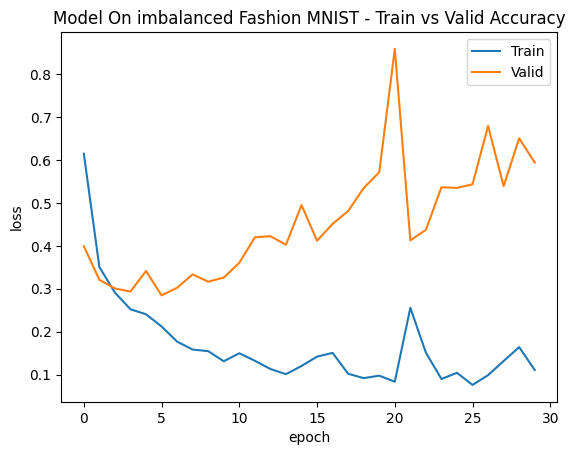

In [13]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Train", "Valid"])
plt.title("Model On imbalanced Fashion MNIST - Train vs Valid Accuracy")

plt.show()

### test on test set

In [14]:
print("On imbalanced Fashion MNIST dataset")
test_acc1, class_percentages1 = test(imbalanced_model, "Imbalanced_model.pth")
print("test accuracy : ", str(test_acc1))

On imbalanced Fashion MNIST dataset

Test dataset: Overall Loss: 0.0018, Overall Accuracy: 7677/10000 (77%)

test accuracy :  76.77


## Cutmix Image Augmentation

In [15]:
# Adapted from https://github.com/clovaai/CutMix-PyTorch/blob/master/train.py


def rand_bbox(size, lam):
    """

    :param size: torch.Size. Shape:(batch_size, channel, image_size, image_size)
    :param lam: cutmix rate
    :return: box boundary
    """
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


def cutmix(data, targets, alpha):
    """

    :param data: torch.Size. Shape:(batch_size, channel, image_size, image_size)
    :param targets: torch.Tensor. multitask, multi-classification, target1. shape(batch_size, 1)
    :param alpha: float, positive
    :return: resulting image, multi-target
    """
    indices = torch.randperm(data.size(0))
    # shuffled_data = data[indices]
    targets_a = targets
    targets_b = targets[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets_a, targets_b, lam]
    return data, targets

In [16]:
def train_cut_mix(
    train_dataloader,
    valid_dataloader,
    PATH,
    model=None,
    criterion=F.cross_entropy,
    epochs=1,
):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    model.train()
    best_acc = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        losses = 0
        for b_i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            X, ys = cutmix(X, y, alpha=0.75)
            pred_prob = model(X)
            targets1, targets2, lam = ys[0], ys[1], ys[2]
            loss = lam * criterion(pred_prob, targets1) + (1 - lam) * criterion(
                pred_prob, targets2
            )
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses += loss.item()  # print(losses)
            if b_i % 10 == 0:
                print(
                    "epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}".format(
                        epoch,
                        b_i,
                        len(train_dataloader),
                        100.0 * b_i / len(train_dataloader),
                        loss.item(),
                    )
                )
        train_losses.append(losses / len(train_dataloader))
        print("\n")
        print("Validation...")
        model.eval()
        success = 0
        total = 0
        losses = 0
        with torch.no_grad():
            for X, y in valid_dataloader:
                X, y = X.to(device), y.to(device)
                pred_prob = model(X)
                loss = criterion(pred_prob, y)  # loss summed across the batch
                losses += loss.item()
                pred = pred_prob.argmax(
                    dim=1, keepdim=True
                )  # use argmax to get the most likely prediction
                success += pred.eq(y.view_as(pred)).sum().item()
                total += len(y)
        val_losses.append(losses / len(valid_dataloader))
        accuracy = 100.0 * success / total

        if accuracy > best_acc:
            torch.save(model.state_dict(), PATH)
            best_acc = accuracy

        print(
            "\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n".format(
                losses / len(valid_dataloader), success, total, accuracy
            )
        )
    return model, train_losses, val_losses

In [17]:
imbalanced_model_cutmix, train_losses, val_losses = train_cut_mix(
    imbalanced_train_loader,
    imbalanced_valid_loader,
    "imbalanced_model_cutmix.pth",
    ConvNet().to(device),
    epochs=30,
)

epoch: 0 [0/187 (0%)]	 training loss: 2.252028
epoch: 0 [10/187 (5%)]	 training loss: 1.752678
epoch: 0 [20/187 (11%)]	 training loss: 1.252409
epoch: 0 [30/187 (16%)]	 training loss: 1.378983
epoch: 0 [40/187 (21%)]	 training loss: 1.156488
epoch: 0 [50/187 (27%)]	 training loss: 1.198630
epoch: 0 [60/187 (32%)]	 training loss: 1.129406
epoch: 0 [70/187 (37%)]	 training loss: 1.186553
epoch: 0 [80/187 (43%)]	 training loss: 1.229246
epoch: 0 [90/187 (48%)]	 training loss: 1.334609
epoch: 0 [100/187 (53%)]	 training loss: 0.574964
epoch: 0 [110/187 (59%)]	 training loss: 1.125413
epoch: 0 [120/187 (64%)]	 training loss: 1.264428
epoch: 0 [130/187 (70%)]	 training loss: 0.669252
epoch: 0 [140/187 (75%)]	 training loss: 1.130286
epoch: 0 [150/187 (80%)]	 training loss: 1.082550
epoch: 0 [160/187 (86%)]	 training loss: 0.695548
epoch: 0 [170/187 (91%)]	 training loss: 0.905360
epoch: 0 [180/187 (96%)]	 training loss: 0.953947


Validation...

Test dataset: Overall Loss: 0.4241, Overall Ac

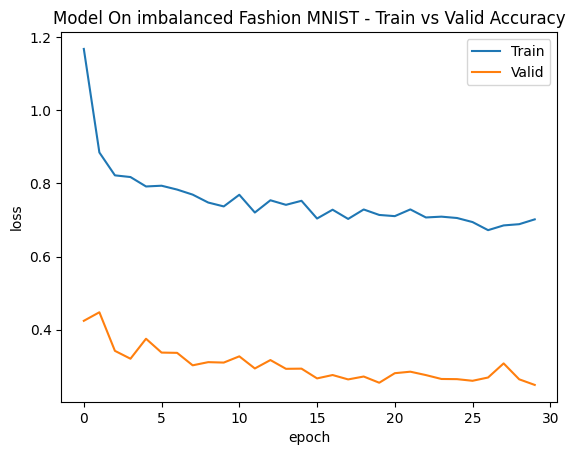

In [18]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Train", "Valid"])
plt.title("Model On imbalanced Fashion MNIST - Train vs Valid Accuracy")

plt.show()

In [19]:
print("On Imbalanced Fashion MNIST dataset")
test_acc2, class_percentages2 = test(
    imbalanced_model_cutmix, "imbalanced_model_cutmix.pth"
)
print("test accuracy : ", str(test_acc2))

On Imbalanced Fashion MNIST dataset

Test dataset: Overall Loss: 0.0012, Overall Accuracy: 8308/10000 (83%)

test accuracy :  83.08


## MixUp


In [20]:
def mixup(data, targets, alpha):
    """

    :param data: torch.Size. Shape:(batch_size, channel, image_size, image_size)
    :param targets: torch.Tensor. multitask, multi-classification, target1. shape(batch_size, 1)
    :param alpha: float, positive
    :return: resulting image, multi-target
    """
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets, shuffled_targets, lam]

    return data, targets

In [21]:
def train_mixup(
    train_dataloader,
    valid_dataloader,
    PATH,
    model=None,
    criterion=F.cross_entropy,
    epochs=1,
):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    model.train()
    best_acc = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        losses = 0
        for b_i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            X, ys = mixup(X, y, alpha=0.5)
            pred_prob = model(X)
            targets1, targets2, lam = ys[0], ys[1], ys[2]
            loss = lam * criterion(pred_prob, targets1) + (1 - lam) * criterion(
                pred_prob, targets2
            )
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses += loss.item()  # print(losses)
            if b_i % 10 == 0:
                print(
                    "epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}".format(
                        epoch,
                        b_i,
                        len(train_dataloader),
                        100.0 * b_i / len(train_dataloader),
                        loss.item(),
                    )
                )
        train_losses.append(losses / len(train_dataloader))
        print("\n")
        print("Validation...")
        model.eval()
        success = 0
        total = 0
        losses = 0
        with torch.no_grad():
            for X, y in valid_dataloader:
                X, y = X.to(device), y.to(device)
                pred_prob = model(X)
                loss = criterion(pred_prob, y)  # loss summed across the batch
                losses += loss.item()
                pred = pred_prob.argmax(
                    dim=1, keepdim=True
                )  # use argmax to get the most likely prediction
                success += pred.eq(y.view_as(pred)).sum().item()
                total += len(y)
        val_losses.append(losses / len(valid_dataloader))
        accuracy = 100.0 * success / total

        if accuracy > best_acc:
            torch.save(model.state_dict(), PATH)
            best_acc = accuracy

        print(
            "\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n".format(
                losses / len(valid_dataloader), success, total, accuracy
            )
        )
    return model, train_losses, val_losses

In [22]:
imbalanced_model_mixup, train_losses, val_losses = train_mixup(
    imbalanced_train_loader,
    imbalanced_valid_loader,
    "imbalanced_model_mixup.pth",
    ConvNet().to(device),
    epochs=30,
)

epoch: 0 [0/187 (0%)]	 training loss: 2.215507
epoch: 0 [10/187 (5%)]	 training loss: 1.454928
epoch: 0 [20/187 (11%)]	 training loss: 1.109699
epoch: 0 [30/187 (16%)]	 training loss: 1.249764
epoch: 0 [40/187 (21%)]	 training loss: 0.730999
epoch: 0 [50/187 (27%)]	 training loss: 0.749751
epoch: 0 [60/187 (32%)]	 training loss: 0.906633
epoch: 0 [70/187 (37%)]	 training loss: 0.822527
epoch: 0 [80/187 (43%)]	 training loss: 0.560227
epoch: 0 [90/187 (48%)]	 training loss: 0.962724
epoch: 0 [100/187 (53%)]	 training loss: 0.585745
epoch: 0 [110/187 (59%)]	 training loss: 0.640926
epoch: 0 [120/187 (64%)]	 training loss: 1.093047
epoch: 0 [130/187 (70%)]	 training loss: 0.760767
epoch: 0 [140/187 (75%)]	 training loss: 1.283033
epoch: 0 [150/187 (80%)]	 training loss: 0.705525
epoch: 0 [160/187 (86%)]	 training loss: 1.221690
epoch: 0 [170/187 (91%)]	 training loss: 0.509333
epoch: 0 [180/187 (96%)]	 training loss: 0.846154


Validation...

Test dataset: Overall Loss: 0.4180, Overall Ac

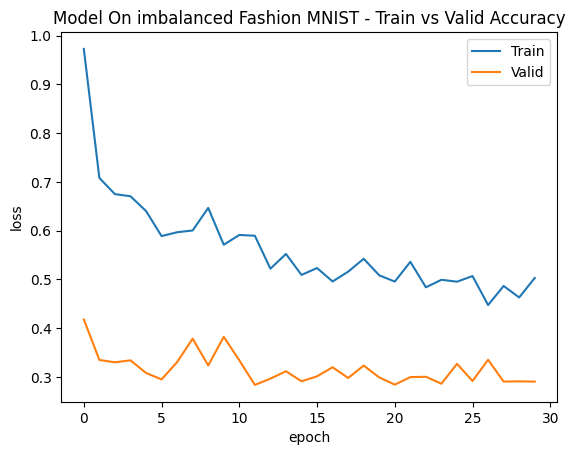

In [23]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Train", "Valid"])
plt.title("Model On imbalanced Fashion MNIST - Train vs Valid Accuracy")

plt.show()

In [24]:
print("On Imbalanced Fashion MNIST dataset")
test_acc3, class_percentages3 = test(
    imbalanced_model_mixup, "imbalanced_model_mixup.pth"
)
print("Mixup test accuracy : ", str(test_acc3))

On Imbalanced Fashion MNIST dataset

Test dataset: Overall Loss: 0.0016, Overall Accuracy: 8095/10000 (81%)

Mixup test accuracy :  80.95


# Cutmix + Mixup

In [25]:
def train_cutmix_mixup(
    train_dataloader,
    valid_dataloader,
    PATH,
    model=None,
    criterion=F.cross_entropy,
    epochs=1,
):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    model.train()
    best_acc = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        losses = 0
        for b_i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            mix_decision = np.random.rand()
            if mix_decision < 0.5:
                X, ys = mixup(X, y, alpha=0.2)
            if mix_decision >= 0.5:
                X, ys = cutmix(X, y, alpha=0.2)
            pred_prob = model(X)
            targets1, targets2, lam = ys[0], ys[1], ys[2]
            loss = lam * criterion(pred_prob, targets1) + (1 - lam) * criterion(
                pred_prob, targets2
            )
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses += loss.item()  # print(losses)
            if b_i % 10 == 0:
                print(
                    "epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}".format(
                        epoch,
                        b_i,
                        len(train_dataloader),
                        100.0 * b_i / len(train_dataloader),
                        loss.item(),
                    )
                )
        train_losses.append(losses / len(train_dataloader))
        print("\n")
        print("Validation...")
        model.eval()
        success = 0
        total = 0
        losses = 0
        with torch.no_grad():
            for X, y in valid_dataloader:
                X, y = X.to(device), y.to(device)
                pred_prob = model(X)
                loss = criterion(pred_prob, y)  # loss summed across the batch
                losses += loss.item()
                pred = pred_prob.argmax(
                    dim=1, keepdim=True
                )  # use argmax to get the most likely prediction
                success += pred.eq(y.view_as(pred)).sum().item()
                total += len(y)
        val_losses.append(losses / len(valid_dataloader))
        accuracy = 100.0 * success / total

        if accuracy > best_acc:
            torch.save(model.state_dict(), PATH)
            best_acc = accuracy

        print(
            "\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n".format(
                losses / len(valid_dataloader), success, total, accuracy
            )
        )
    return model, train_losses, val_losses

In [26]:
imbalanced_model_cutmix_mixup, train_losses, val_losses = train_mixup(
    imbalanced_train_loader,
    imbalanced_valid_loader,
    "imbalanced_model_cutmix_mixup.pth",
    ConvNet().to(device),
    epochs=30,
)

epoch: 0 [0/187 (0%)]	 training loss: 2.315036
epoch: 0 [10/187 (5%)]	 training loss: 1.186607
epoch: 0 [20/187 (11%)]	 training loss: 1.119953
epoch: 0 [30/187 (16%)]	 training loss: 1.213618
epoch: 0 [40/187 (21%)]	 training loss: 0.466097
epoch: 0 [50/187 (27%)]	 training loss: 0.735462
epoch: 0 [60/187 (32%)]	 training loss: 1.197388
epoch: 0 [70/187 (37%)]	 training loss: 0.692525
epoch: 0 [80/187 (43%)]	 training loss: 1.140825
epoch: 0 [90/187 (48%)]	 training loss: 0.753436
epoch: 0 [100/187 (53%)]	 training loss: 1.333978
epoch: 0 [110/187 (59%)]	 training loss: 0.954575
epoch: 0 [120/187 (64%)]	 training loss: 0.910197
epoch: 0 [130/187 (70%)]	 training loss: 1.080289
epoch: 0 [140/187 (75%)]	 training loss: 0.695642
epoch: 0 [150/187 (80%)]	 training loss: 0.944699
epoch: 0 [160/187 (86%)]	 training loss: 0.712580
epoch: 0 [170/187 (91%)]	 training loss: 0.582688
epoch: 0 [180/187 (96%)]	 training loss: 1.018334


Validation...

Test dataset: Overall Loss: 0.3616, Overall Ac

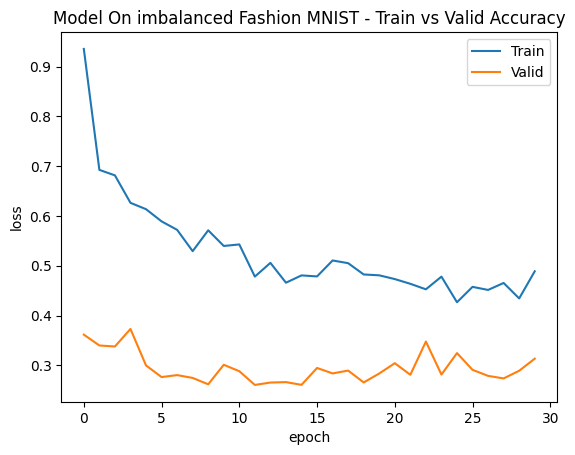

In [27]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Train", "Valid"])
plt.title("Model On imbalanced Fashion MNIST - Train vs Valid Accuracy")

plt.show()

In [28]:
print("On Imbalanced Fashion MNIST dataset")
test_acc4, class_percentages4 = test(
    imbalanced_model_cutmix_mixup, "imbalanced_model_cutmix_mixup.pth"
)
print("Cutmix+Mixup test accuracy : ", str(test_acc4))

On Imbalanced Fashion MNIST dataset

Test dataset: Overall Loss: 0.0015, Overall Accuracy: 8140/10000 (81%)

Cutmix+Mixup test accuracy :  81.4


# ReMix

In [29]:
Counter(imbalanced_train_dataset.targets.numpy())

Counter({0: 6000,
         3: 1292,
         9: 60,
         1: 3596,
         5: 464,
         6: 278,
         2: 2156,
         4: 774,
         7: 166,
         8: 100})

In [30]:
def remix_data(inputs, labels, class_counts, alpha=1.0):
    """
    Returns mixed inputs, pairs of targets, and lambda_x, lambda_y
    """
    if alpha > 0:
        lambda_x = np.random.beta(alpha, alpha)
    else:
        lambda_x = 1

    K = 3  # hyperparameter for majority class
    tau = 0.5  # hyperparameter

    class_counts_tensor = torch.tensor(class_counts)
    batch_size = inputs.size()[0]
    random_indices = torch.randperm(batch_size)

    class_count_pairs = [
        [class_counts_tensor[labels[i]].item(), class_counts_tensor[labels[j]].item()]
        for i, j in enumerate(random_indices)
    ]
    class_count_pairs = torch.tensor(class_count_pairs)

    lambda_y_values = []
    for pair in class_count_pairs:
        class_count_ratio = pair[0] / pair[1]

        if class_count_ratio >= K and lambda_x < tau:
            lambda_y_values.append(0)
        elif class_count_ratio <= (1 / K) and (1 - lambda_x) < tau:
            lambda_y_values.append(1)
        else:
            lambda_y_values.append(lambda_x)

    lambda_y = torch.tensor(lambda_y_values).cuda(0)
    mixed_inputs = lambda_x * inputs + (1 - lambda_x) * inputs[random_indices, :]
    labels_a, labels_b = labels, labels[random_indices]

    return mixed_inputs, [labels_a, labels_b, lambda_y]

In [31]:
def remix_criterion(criterion, pred, y_a, y_b, lam_y):
    """
    In Remix, the lambda for mixing label is different from original mixup.
    """
    # for each y, we calculated its loss individually with their respective
    # lambda_y
    loss = torch.mul(criterion(pred, y_a), lam_y) + torch.mul(
        criterion(pred, y_b), (1 - lam_y)
    )
    return loss.mean()


def train_remix(
    cls_num_list,
    train_dataloader,
    valid_dataloader,
    PATH,
    model=None,
    criterion=F.cross_entropy,
    epochs=1,
):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    model.train()
    best_acc = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        losses = 0
        for b_i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            X, ys = remix_data(X, y, cls_num_list, alpha=0.5)
            pred_prob = model(X)
            targets1, targets2, lam = ys[0], ys[1], ys[2]
            loss = remix_criterion(criterion, pred_prob, targets1, targets2, lam)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses += loss.item()  # print(losses)
            if b_i % 10 == 0:
                print(
                    "epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}".format(
                        epoch,
                        b_i,
                        len(train_dataloader),
                        100.0 * b_i / len(train_dataloader),
                        loss.item(),
                    )
                )
        train_losses.append(losses / len(train_dataloader))
        print("\n")
        print("Validation...")
        model.eval()
        success = 0
        total = 0
        losses = 0
        with torch.no_grad():
            for X, y in valid_dataloader:
                X, y = X.to(device), y.to(device)
                pred_prob = model(X)
                loss = criterion(pred_prob, y)  # loss summed across the batch
                losses += loss.item()
                pred = pred_prob.argmax(
                    dim=1, keepdim=True
                )  # use argmax to get the most likely prediction
                success += pred.eq(y.view_as(pred)).sum().item()
                total += len(y)
        val_losses.append(losses / len(valid_dataloader))
        accuracy = 100.0 * success / total

        if accuracy > best_acc:
            torch.save(model.state_dict(), PATH)
            best_acc = accuracy

        print(
            "\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n".format(
                losses / len(valid_dataloader), success, total, accuracy
            )
        )
    return model, train_losses, val_losses

In [32]:
per_class_count_dict = dict(Counter(imbalanced_train_dataset.targets.numpy()))
cls_num_list = []
for i in range(10):
    cls_num_list.append(per_class_count_dict[i])
print(cls_num_list)

[6000, 3596, 2156, 1292, 774, 464, 278, 166, 100, 60]


In [33]:
imbalanced_model_remix, train_losses, val_losses = train_remix(
    cls_num_list,
    imbalanced_train_loader,
    imbalanced_valid_loader,
    "imbalanced_model_remix.pth",
    ConvNet().to(device),
    epochs=30,
)

epoch: 0 [0/187 (0%)]	 training loss: 2.339584
epoch: 0 [10/187 (5%)]	 training loss: 1.239786
epoch: 0 [20/187 (11%)]	 training loss: 1.204120
epoch: 0 [30/187 (16%)]	 training loss: 0.894693
epoch: 0 [40/187 (21%)]	 training loss: 1.224142
epoch: 0 [50/187 (27%)]	 training loss: 0.820298
epoch: 0 [60/187 (32%)]	 training loss: 1.001780
epoch: 0 [70/187 (37%)]	 training loss: 1.237055
epoch: 0 [80/187 (43%)]	 training loss: 0.533003
epoch: 0 [90/187 (48%)]	 training loss: 1.195767
epoch: 0 [100/187 (53%)]	 training loss: 0.983461
epoch: 0 [110/187 (59%)]	 training loss: 0.781501
epoch: 0 [120/187 (64%)]	 training loss: 0.761184
epoch: 0 [130/187 (70%)]	 training loss: 0.345647
epoch: 0 [140/187 (75%)]	 training loss: 0.913522
epoch: 0 [150/187 (80%)]	 training loss: 1.177918
epoch: 0 [160/187 (86%)]	 training loss: 0.941176
epoch: 0 [170/187 (91%)]	 training loss: 0.509522
epoch: 0 [180/187 (96%)]	 training loss: 0.733694


Validation...

Test dataset: Overall Loss: 0.4411, Overall Ac

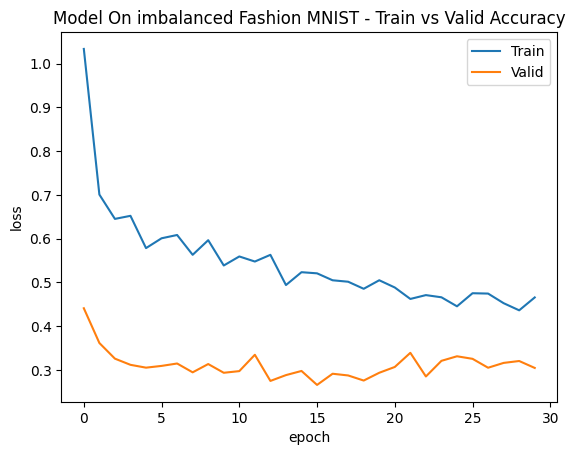

In [34]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Train", "Valid"])
plt.title("Model On imbalanced Fashion MNIST - Train vs Valid Accuracy")

plt.show()

In [35]:
print("On Imbalanced Fashion MNIST dataset")
test_acc5, class_percentages5 = test(
    imbalanced_model_remix, "imbalanced_model_remix.pth"
)
print("Remix test accuracy : ", str(test_acc5))

On Imbalanced Fashion MNIST dataset

Test dataset: Overall Loss: 0.0015, Overall Accuracy: 8051/10000 (81%)

Remix test accuracy :  80.51


# comparison

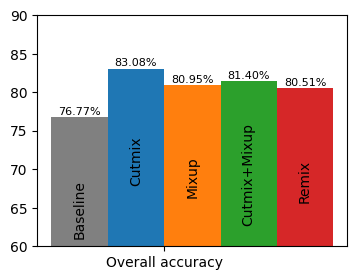

In [36]:
fig = plt.subplots(figsize=(4, 3))

br1 = np.arange(1)
br2 = [x + 0.1 for x in br1]
br3 = [x + 0.1 for x in br2]
br4 = [x + 0.1 for x in br3]
br5 = [x + 0.1 for x in br4]

p1 = plt.bar(
    br1,
    np.array(test_acc1).astype(float),
    width=0.1,
    label="Baseline model",
    color="gray",
)
p2 = plt.bar(br2, np.array(test_acc2).astype(float), width=0.1, label="cutmix model")
p3 = plt.bar(br3, np.array(test_acc3).astype(float), width=0.1, label="mixup model")
p4 = plt.bar(
    br4, np.array(test_acc4).astype(float), width=0.1, label="cutmix + mixup model"
)
p5 = plt.bar(br5, np.array(test_acc5).astype(float), width=0.1, label="remix model")

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate(
        "{:.2f}%".format(height),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=8,
    )
    plt.text(
        (rect1.get_x() + rect1.get_width() / 2),
        height - 12,
        "Baseline",
        ha="center",
        va="center",
        rotation=90,
    )
for rect1 in p2:
    height = rect1.get_height()
    plt.annotate(
        "{:.2f}%".format(height),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=8,
    )
    plt.text(
        (rect1.get_x() + rect1.get_width() / 2),
        height - 12,
        "Cutmix",
        ha="center",
        va="center",
        rotation=90,
    )
for rect1 in p3:
    height = rect1.get_height()
    plt.annotate(
        "{:.2f}%".format(height),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=8,
    )
    plt.text(
        (rect1.get_x() + rect1.get_width() / 2),
        height - 12,
        "Mixup",
        ha="center",
        va="center",
        rotation=90,
    )
for rect1 in p4:
    height = rect1.get_height()
    plt.annotate(
        "{:.2f}%".format(height),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=8,
    )
    plt.text(
        (rect1.get_x() + rect1.get_width() / 2),
        height - 12,
        "Cutmix+Mixup",
        ha="center",
        va="center",
        rotation=90,
    )
for rect1 in p5:
    height = rect1.get_height()
    plt.annotate(
        "{:.2f}%".format(height),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=8,
    )
    plt.text(
        (rect1.get_x() + rect1.get_width() / 2),
        height - 12,
        "Remix",
        ha="center",
        va="center",
        rotation=90,
    )


plt.xticks([r + 0.15 for r in range(1)], ["Overall accuracy"])
plt.ylim(60, 90)
plt.show()

In [37]:
df = pd.DataFrame(
    {
        "Baseline": class_percentages1,
        "Cutmix": class_percentages2,
        "Mixup": class_percentages3,
        "Cutmix+Mixup": class_percentages4,
        "Remix": class_percentages5,
    }
)

df

,Baseline,Cutmix,Mixup,Cutmix+Mixup,Remix
0,0.923077,0.980769,0.923077,0.961538,0.903846
1,0.983871,1.000000,0.967742,0.983871,0.983871
2,0.851064,0.829787,0.872340,0.829787,0.957447
3,0.976190,0.976190,0.904762,0.952381,0.952381
4,0.680851,0.765957,0.744681,0.872340,0.851064
5,1.000000,0.980392,0.960784,0.980392,1.000000
6,0.288889,0.311111,0.333333,0.333333,0.333333
7,0.795918,0.938776,0.979592,0.918367,0.836735
8,0.733333,0.900000,0.733333,0.650000,0.666667
9,0.688889,0.888889,0.800000,0.755556,0.888889


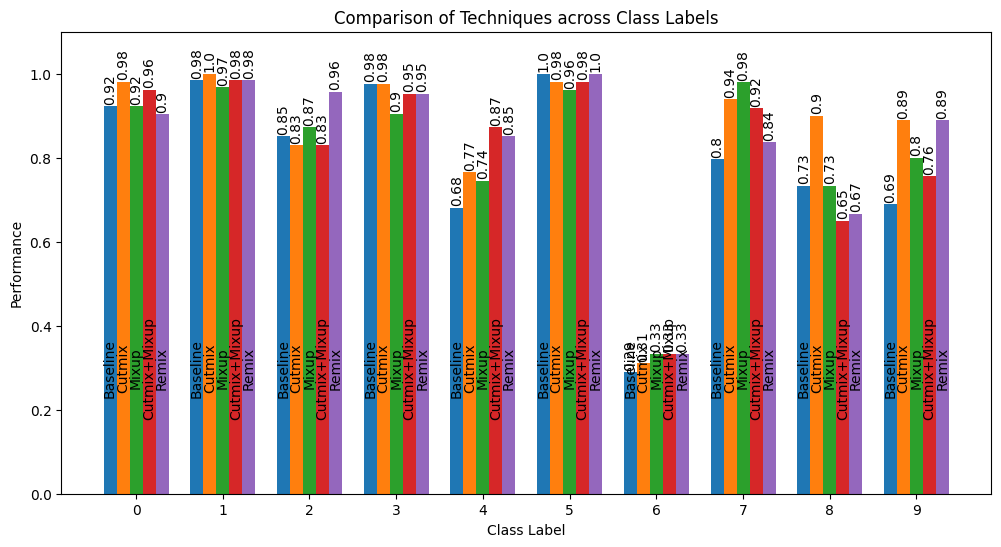

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Set the width of the bars
bar_width = 0.15

# Set the positions of the bars
r1 = np.arange(len(df["Baseline"]))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]

plt.figure(figsize=(12, 6))

# Create the bars
bars1 = plt.bar(r1, df["Baseline"], width=bar_width)
bars2 = plt.bar(r2, df["Cutmix"], width=bar_width)
bars3 = plt.bar(r3, df["Mixup"], width=bar_width)
bars4 = plt.bar(r4, df["Cutmix+Mixup"], width=bar_width)
bars5 = plt.bar(r5, df["Remix"], width=bar_width)


# Function to add technique labels at the bottom of the bars
def add_technique_labels(bars, positions, label):
    for bar, pos in zip(bars, positions):
        plt.text(pos, 0.3, label, ha="center", va="center", rotation=90)
        height = bar.get_height()
        plt.text(
            pos, height + 0.005, f"{height:.2}", ha="center", va="bottom", rotation=90
        )


# Add technique labels
add_technique_labels(bars1, r1, "Baseline")
add_technique_labels(bars2, r2, "Cutmix")
add_technique_labels(bars3, r3, "Mixup")
add_technique_labels(bars4, r4, "Cutmix+Mixup")
add_technique_labels(bars5, r5, "Remix")

# Add labels and title
plt.xlabel("Class Label")
plt.ylabel("Performance")
plt.title("Comparison of Techniques across Class Labels")
plt.xticks([r + bar_width * 2 for r in range(len(df["Baseline"]))], df.index)
plt.ylim(0, 1.1)
plt.show()

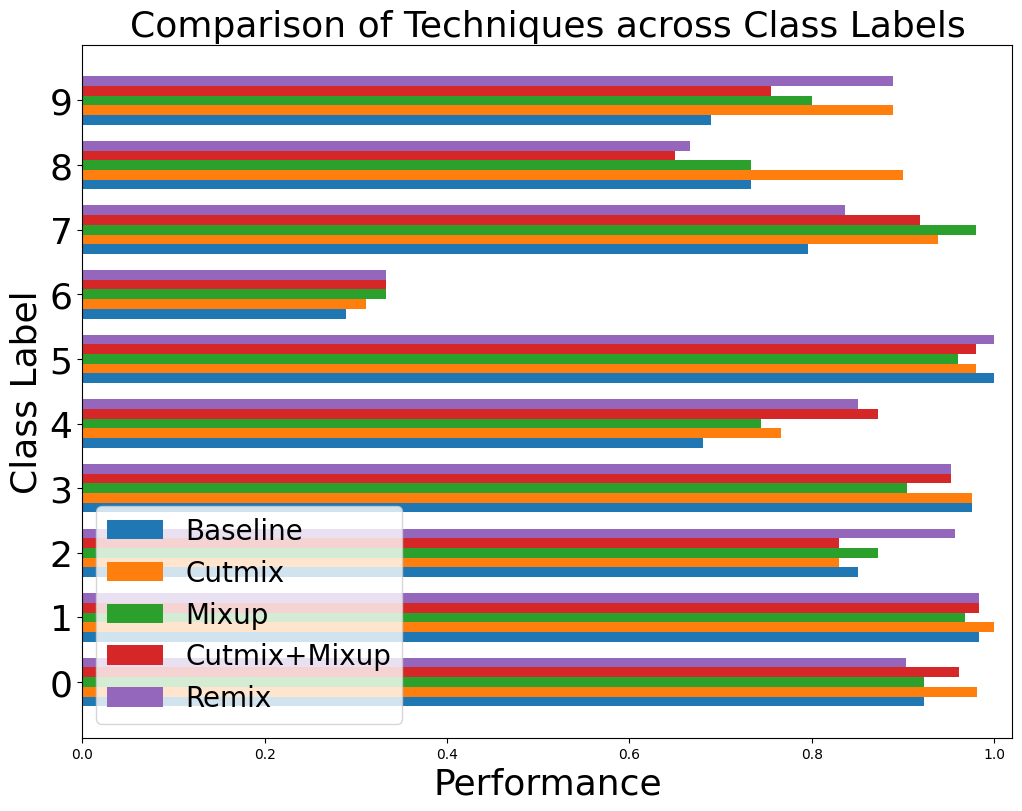

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# Set the height of the bars
bar_height = 0.15

# Set the positions of the bars
r1 = np.arange(len(df["Baseline"]))
r2 = [x + bar_height for x in r1]
r3 = [x + bar_height for x in r2]
r4 = [x + bar_height for x in r3]
r5 = [x + bar_height for x in r4]

plt.figure(figsize=(12, 9))

# Create the bars with labels for the legend
bars1 = plt.barh(r1, df["Baseline"], height=bar_height, label="Baseline")
bars2 = plt.barh(r2, df["Cutmix"], height=bar_height, label="Cutmix")
bars3 = plt.barh(r3, df["Mixup"], height=bar_height, label="Mixup")
bars4 = plt.barh(r4, df["Cutmix+Mixup"], height=bar_height, label="Cutmix+Mixup")
bars5 = plt.barh(r5, df["Remix"], height=bar_height, label="Remix")


# bars1 = plt.barh(r1, df['Baseline'], height=bar_height, hatch='//', edgecolor='black', label='Baseline')
# bars2 = plt.barh(r2, df['Cutmix'], height=bar_height, hatch='\\', edgecolor='black', label='Cutmix')
# bars3 = plt.barh(r3, df['Mixup'], height=bar_height, hatch='--', edgecolor='black', label='Mixup')
# bars4 = plt.barh(r4, df['Cutmix+Mixup'], height=bar_height, hatch='++', edgecolor='black', label='Cutmix+Mixup')
# bars5 = plt.barh(r5, df['Remix'], height=bar_height, hatch='xx', edgecolor='black', label='Remix')

# bars1 = plt.barh(r1, df['Baseline'], height=bar_height, color='0.2', linewidth=1, label='Baseline')
# bars2 = plt.barh(r2, df['Cutmix'], height=bar_height, color='0.4',  linewidth=1, label='Cutmix')
# bars3 = plt.barh(r3, df['Mixup'], height=bar_height, color='0.6', linewidth=1, label='Mixup')
# bars4 = plt.barh(r4, df['Cutmix+Mixup'], height=bar_height, color='0.8', linewidth=1, label='Cutmix+Mixup')
# bars5 = plt.barh(r5, df['Remix'], height=bar_height, color='1.0', linewidth=2, label='Remix')


# Add labels and title
plt.ylabel("Class Label", fontsize=26)
plt.xlabel("Performance", fontsize=26)
plt.title("Comparison of Techniques across Class Labels", fontsize=26)
plt.yticks(
    [r + bar_height * 2 for r in range(len(df["Baseline"]))], df.index, fontsize=26
)
plt.xlim(0, 1.02)

plt.legend(loc="lower left", fontsize=20)
# plt.legend(bbox_to_anchor=(0., .25), loc='upper left', fontsize=26)

plt.show()